<a href="https://colab.research.google.com/github/varlottaang/matching/blob/main/examples/weights/MatchWeightsTimePath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install sentence-transformers

In [ ]:
!pip install -U sentence-transformers

In [ ]:
# Import packages
import pandas as pd
from sentence_transformers import SentenceTransformer, util

In [ ]:
# Load CSV files
mentors_df = pd.read_csv('mentors.csv')
mentees_df = pd.read_csv('mentees.csv')

In [ ]:
# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Load CSV files
mentors_df = pd.read_csv("mentors.csv")
mentees_df = pd.read_csv("mentees.csv")

# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to adjust keywords by their order of importance
def adjust_keywords_by_order(keywords):
    weighted_keywords = []
    weights = [5, 4, 3, 2, 1]  # Weights from highest to lowest importance
    for keyword, weight in zip(keywords.split(', '), weights):
        weighted_keywords.extend([keyword] * weight)
    return ', '.join(weighted_keywords)

# Function to compute embeddings for adjusted keywords
def compute_embeddings(dataframe):
    return model.encode(dataframe["adjusted_keywords"].tolist(), convert_to_tensor=True)

# Initialize sets to track matched mentees and mentors
matched_mentees = set()
matched_mentors = set()

# Matching process (including grouping by timezone and career path)
unique_timezones = mentors_df["timezone"].unique()
career_paths = ["academia", "industry"]  # career paths
all_matches_df = pd.DataFrame(columns=['Mentee', 'Mentor', 'Similarity Score'])

for timezone in unique_timezones:
    for career_path in career_paths:
        filtered_mentors = mentors_df[(mentors_df["timezone"] == timezone) & (mentors_df["career"] == career_path)].copy()
        filtered_mentees = mentees_df[(mentees_df["timezone"] == timezone) & (mentees_df["career"] == career_path)].copy()

        if filtered_mentors.empty or filtered_mentees.empty:
            continue

        filtered_mentors['adjusted_keywords'] = filtered_mentors['keywords'].apply(adjust_keywords_by_order)
        filtered_mentees['adjusted_keywords'] = filtered_mentees['keywords'].apply(adjust_keywords_by_order)

        mentor_embeddings = compute_embeddings(filtered_mentors)
        mentee_embeddings = compute_embeddings(filtered_mentees)

        mentor_match_count = {mentor: 0 for mentor in filtered_mentors['name_id']}
        matches_per_mentor = max(len(filtered_mentees) // len(filtered_mentors), 1)
        matches_with_scores = []

        for mentee_idx, mentee_embedding in enumerate(mentee_embeddings):
            similarities = util.cos_sim(mentee_embedding, mentor_embeddings)[0]
            for best_match_idx in similarities.argsort(descending=True):
                best_match_idx = best_match_idx.item()
                mentor_name = filtered_mentors['name_id'].iloc[best_match_idx]

                if mentor_match_count[mentor_name] < matches_per_mentor:
                    mentee_name = filtered_mentees['name_id'].iloc[mentee_idx]
                    similarity_score = similarities[best_match_idx].item()

                    matches_with_scores.append((mentee_name, mentor_name, similarity_score))
                    mentor_match_count[mentor_name] += 1

                    # Track matched mentees and mentors
                    matched_mentees.add(mentee_name)
                    matched_mentors.add(mentor_name)
                    break

        current_matches_df = pd.DataFrame(matches_with_scores, columns=['Mentee', 'Mentor', 'Similarity Score'])
        all_matches_df = pd.concat([all_matches_df, current_matches_df], ignore_index=True)

# Print the first few matches to verify
print(all_matches_df.head())

      Mentee      Mentor  Similarity Score
0  Mentee_18  Mentor_122          0.802822
1  Mentee_23  Mentor_122          0.848902
2  Mentee_24   Mentor_65          0.793541
3  Mentee_41   Mentor_65          0.803125
4  Mentee_43  Mentor_122          0.868207


In [ ]:
# Save the DataFrame to a CSV file
all_matches_df.to_csv("mentee_mentor_matches_grouped_by_career_path.csv", index=False)



In [ ]:
# Identify unmatched mentees and mentors
unmatched_mentors = mentors_df[~mentors_df["name_id"].isin(matched_mentors)]
unmatched_mentees = mentees_df[~mentees_df["name_id"].isin(matched_mentees)]

# Print unmatched mentees
print("Unmatched Mentees:")
print(unmatched_mentees)

# Print unmatched mentors
print("\nUnmatched Mentors:")
print(unmatched_mentors)


Unmatched Mentees:
        name_id                                           keywords  \
294  Mentee_295  ['heatwaves', 'climate modeling', 'ocean reana...   
304  Mentee_305  ['ocean acidification', 'climate modeling', 'l...   
358  Mentee_359  ['climate future', 'adaptation and impact', 'a...   
369  Mentee_370  ['paleoclimate', 'adaptation and impact', 'sea...   
371  Mentee_372  ['climate modeling', 'climate data', 'climate ...   
..          ...                                                ...   
453  Mentee_454  ['climate system', 'land use', 'sea level rise...   
454  Mentee_455  ['ENSO', 'atmosphere reanalysis', 'climate dat...   
455  Mentee_456  ['ocean reanalysis', 'atmosphere reanalysis', ...   
456  Mentee_457  ['sea level rise', 'climate data', 'climate fu...   
457  Mentee_458  ['sea level rise', 'climate response', 'paleoc...   

                                           description    career  \
294  With a profound interest in environmental scie...  academia   
304 

In [ ]:
### Unmatched mentees

In [ ]:
# Adjust keywords and compute embeddings for unmatched mentees
# Ensure to work on a copy to avoid SettingWithCopyWarning
unmatched_mentees = unmatched_mentees.copy()
unmatched_mentees["adjusted_keywords"] = unmatched_mentees["keywords"].apply(adjust_keywords_by_order)
unmatched_mentee_embeddings = compute_embeddings(unmatched_mentees)

# Use .copy() to avoid the warning when modifying the all_mentors DataFrame
all_mentors = mentors_df.copy()
all_mentors["adjusted_keywords"] = all_mentors["keywords"].apply(adjust_keywords_by_order)
all_mentor_embeddings = compute_embeddings(all_mentors)

# Perform matching based on similarity
additional_matches_with_scores = []

for mentee_idx, mentee_embedding in enumerate(unmatched_mentee_embeddings):
    mentee_name = unmatched_mentees["name_id"].iloc[mentee_idx]
    similarities = util.cos_sim(mentee_embedding, all_mentor_embeddings)[0]

    # Find the best match for each unmatched mentee
    best_match_idx = similarities.argmax().item()
    mentor_name = all_mentors["name_id"].iloc[best_match_idx]
    similarity_score = similarities[best_match_idx].item()

    # Initialize mentor_match_count if not already done
    if mentor_name not in mentor_match_count:
        mentor_match_count[mentor_name] = 0

    # Check if the mentor can take more mentees
    if mentor_match_count[mentor_name] < matches_per_mentor:
        additional_matches_with_scores.append((mentee_name, mentor_name, similarity_score))

        # Update tracking
        matched_mentees.add(mentee_name)
        matched_mentors.add(mentor_name)
        mentor_match_count[mentor_name] += 1


In [ ]:
#Update the Matches DataFrame
additional_matches_df = pd.DataFrame(additional_matches_with_scores, columns=['Mentee', 'Mentor', 'Similarity Score'])
all_matches_df = pd.concat([all_matches_df, additional_matches_df], ignore_index=True)

# Print and save the final matches
print(all_matches_df)
all_matches_df.to_csv("final_mentee_mentor_matches.csv", index=False)



         Mentee      Mentor  Similarity Score
0     Mentee_18  Mentor_122          0.802822
1     Mentee_23  Mentor_122          0.848902
2     Mentee_24   Mentor_65          0.793541
3     Mentee_41   Mentor_65          0.803125
4     Mentee_43  Mentor_122          0.868207
..          ...         ...               ...
443  Mentee_452   Mentor_84          0.926732
444  Mentee_455   Mentor_36          0.940537
445  Mentee_456   Mentor_66          0.943172
446  Mentee_457   Mentor_16          0.945738
447  Mentee_458  Mentor_116          0.980580

[448 rows x 3 columns]


In [ ]:
#### FINAL CSV

In [14]:
import pandas as pd

# Load the CSV files
mentees_df = pd.read_csv("mentees.csv")
mentors_df = pd.read_csv("mentors.csv")
matches_df = pd.read_csv("final_mentee_mentor_matches.csv")

# Merge mentee info
matches_with_mentee_info = pd.merge(matches_df, mentees_df[["name_id", "career", "timezone"]], left_on="Mentee", right_on="name_id", how="left")
matches_with_mentee_info.rename(columns={"career": "Mentee_Career", "timezone": "Mentee_Timezone"}, inplace=True)

# Merge mentor info
final_matches_df = pd.merge(matches_with_mentee_info, mentors_df[["name_id", "career", "timezone"]], left_on="Mentor", right_on="name_id", how="left")
final_matches_df.rename(columns={"career": "Mentor_Career", "timezone": "Mentor_Timezone"}, inplace=True)

# Drop the extra 'name_id' columns
final_matches_df.drop(columns=["name_id_x", "name_id_y"], inplace=True)

# Selecting only the required columns for the combined CSV
combined_matches_df = final_matches_df[["Mentee", "Mentor", "Similarity Score", "Mentee_Career", "Mentee_Timezone", "Mentor_Career", "Mentor_Timezone"]]

# Save the combined DataFrame to a new CSV file
combined_matches_df.to_csv('combined_final_mentee_mentor_matches.csv', index=False)

In [ ]:
#### STILL UNMATCHED Mentees - sob :)

In [ ]:
# Set of all mentee IDs
all_mentee_ids = set(mentees_df["name_id"])

# Check if all mentees have been matched
if all_mentee_ids == matched_mentees:
    print("All mentees have been matched.")
else:
    # Identify mentees who haven't been matched
    unmatched_mentee_ids = all_mentee_ids - matched_mentees
    print("Some mentees have not been matched:", unmatched_mentee_ids)


Some mentees have not been matched: {'Mentee_409', 'Mentee_453', 'Mentee_388', 'Mentee_384', 'Mentee_305', 'Mentee_454', 'Mentee_424', 'Mentee_437', 'Mentee_431', 'Mentee_377'}


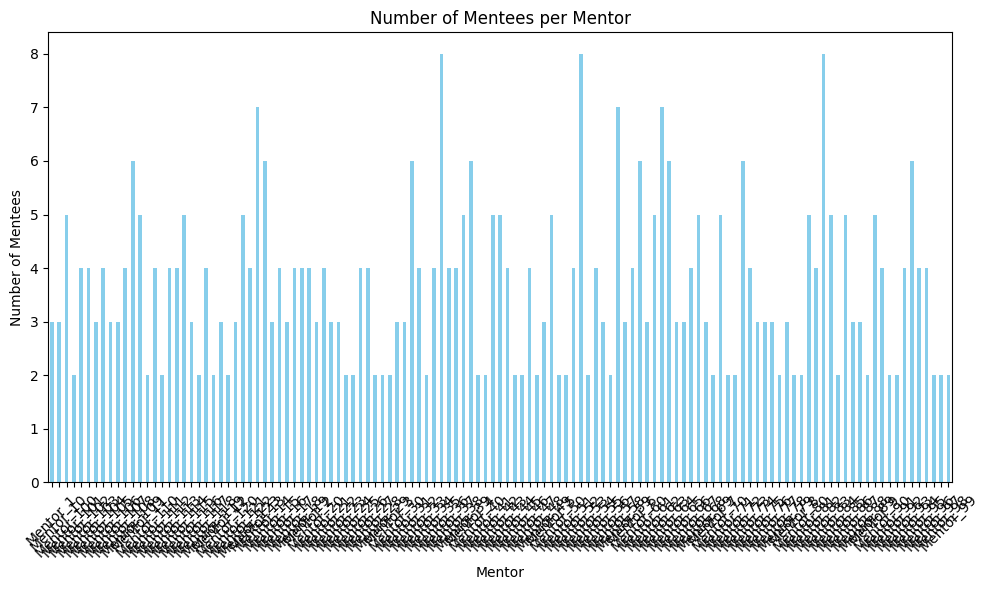

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming all_matches_df is the DataFrame containing the matches
# Count the number of mentees per mentor
mentees_per_mentor = all_matches_df.groupby('Mentor')['Mentee'].count()

# Plotting directly with pandas
mentees_per_mentor.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Adding titles and labels
plt.title('Number of Mentees per Mentor')
plt.xlabel('Mentor')
plt.ylabel('Number of Mentees')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()


In [ ]:
# Timezones and Career Comparison

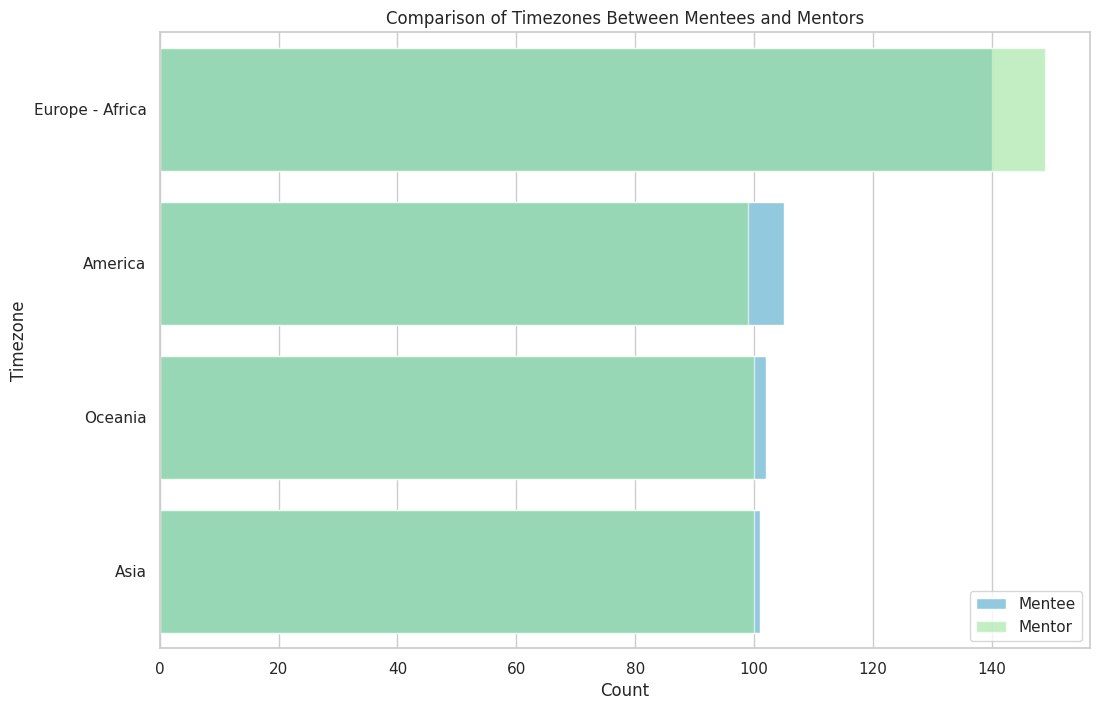

<ipython-input-15-8fcb427d7121>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Career_Match", data=final_matches_df, order=career_order, palette='Set3')


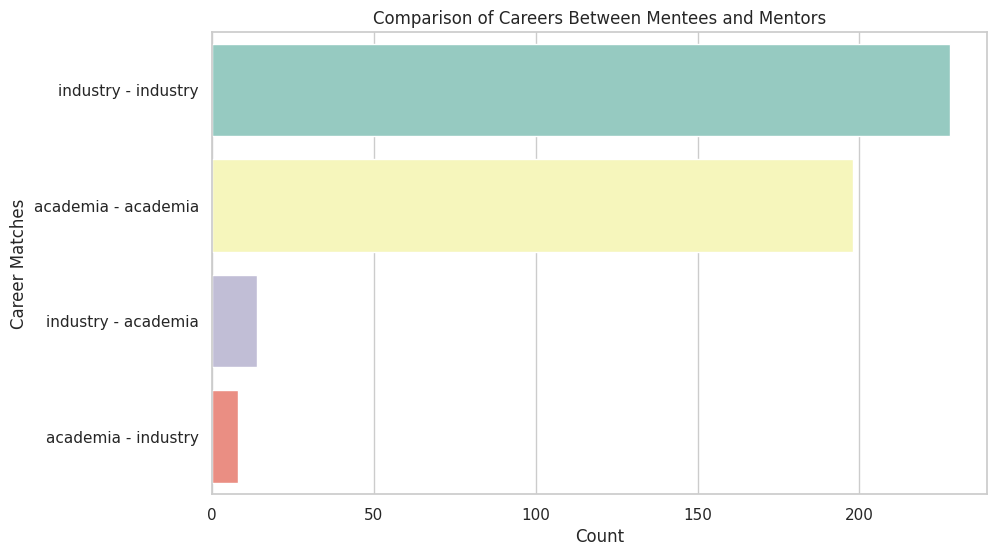

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files into DataFrames
mentees_df = pd.read_csv('mentees.csv')
mentors_df = pd.read_csv('mentors.csv')
matches_df = pd.read_csv('final_mentee_mentor_matches.csv')

# Merge mentee and mentor information into the matches DataFrame
matches_with_mentee_info = pd.merge(matches_df, mentees_df[['name_id', 'career', 'timezone']], left_on='Mentee', right_on='name_id', how='left')
matches_with_mentee_info.rename(columns={'career': 'Mentee_Career', 'timezone': 'Mentee_Timezone'}, inplace=True)

final_matches_df = pd.merge(matches_with_mentee_info, mentors_df[['name_id', 'career', 'timezone']], left_on='Mentor', right_on='name_id', how='left')
final_matches_df.rename(columns={'career': 'Mentor_Career', 'timezone': 'Mentor_Timezone'}, inplace=True)

# Drop the extra 'name_id' columns
final_matches_df.drop(columns=['name_id_x', 'name_id_y'], inplace=True)

# Visualization 1: Timezone comparison
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.countplot(y="Mentee_Timezone", data=final_matches_df, order=final_matches_df['Mentee_Timezone'].value_counts().index, color='skyblue', label='Mentee')
sns.countplot(y="Mentor_Timezone", data=final_matches_df, order=final_matches_df['Mentee_Timezone'].value_counts().index, color='lightgreen', label='Mentor', alpha=0.6)
plt.legend(loc='best')
plt.title('Comparison of Timezones Between Mentees and Mentors')
plt.xlabel('Count')
plt.ylabel('Timezone')
plt.show()

# Visualization 2: Career comparison
plt.figure(figsize=(10, 6))
final_matches_df['Career_Match'] = final_matches_df['Mentee_Career'] + " - " + final_matches_df['Mentor_Career']
career_order = final_matches_df['Career_Match'].value_counts().index
sns.countplot(y="Career_Match", data=final_matches_df, order=career_order, palette='Set3')
plt.title('Comparison of Careers Between Mentees and Mentors')
plt.xlabel('Count')
plt.ylabel('Career Matches')
plt.show()
